In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import pycaret
#from pycaret.classification import *
#from pycaret.classification import ClassificationExperiment

from kmodes.kmodes import KModes
from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings("ignore")

## Datasets

In [14]:
df = pd.read_csv('../../Data/cardio_data.csv')
df.head()

,age,gender,height,weight,systolic,diastolic,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease,BMI
0,50,2,168,62,110,80,1,1,0,0,1,0,21
1,55,1,156,85,140,90,3,1,0,0,1,1,34
2,51,1,165,64,130,70,3,1,0,0,0,1,23
3,48,2,169,82,150,100,1,1,0,0,1,1,28
4,47,1,156,56,100,60,1,1,0,0,0,0,23


## Transforming Dataset

In [15]:
# Transforming the column AGE(measured in days) for Age_Bin
# age_bin in quinquenium 5 years spam
df['age_bin'] = pd.cut(df['age'], [0,20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100], 
                              labels=['0-20', '20-30', '30-35', '35-40','40-45','45-50','50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','90-95','95-100'])

Here, I am grouping or binning `age` column into categories based on a 5-year interval. `Age_bin` is a variable or column name that likely contains individual age values, while `quinquenium` refers to a period of 5 years.

For example, if we have a dataset with age information, we can use this method to group the ages into 5-year intervals, such as 0-4 years, 5-9 years, 10-14 years, and so on. Each of these intervals can then be assigned a label or category, such as "0-4", "5-9", "10-14", etc., which can be used as input for statistical analyses or machine learning algorithms.

In [16]:
# Transforming the column bmi in Body Mass Index Classes (1 to 6)

# Adding Body Mass Index
df['bmi'] = df['weight']/((df['height']/100)**2)

rating = []
for row in df['bmi']:
    if row < 18.5 :    
        rating.append(1) #UnderWeight
    elif row > 18.5 and row  < 24.9:   
        rating.append(2) #NormalWeight
    elif row > 24.9 and row < 29.9:  
        rating.append(3) #OverWeight
    elif row > 29.9 and row < 34.9:  
        rating.append(4) #ClassObesity_1
    elif row > 34.9 and row < 39.9:  
        rating.append(5) #ClassObesity_2
    elif row > 39.9 and row < 49.9:  
        rating.append(6) #ClassObesity_3
    elif row > 49.9:  
        rating.append('Error')
        
    else:           
        rating.append('Not_Rated')

# inserting Column
df['BMI_Class'] = rating

In [17]:
# creating a Column for MAP
df['MAP'] = ((2* df['diastolic']) + df['systolic']) / 3

#Creating Classes for MAP
map_values = []
for row in df['MAP']:
    if row < 69.9:    
        map_values.append(1) #Low
    elif row > 70 and row  < 79.9:   
        map_values.append(2)#Normal
    elif row > 79.9 and row < 89.9:  
        map_values.append(3)#Normal
    elif row > 89.9 and row < 99.9:  
        map_values.append(4)#Normal
    elif row > 99.9 and row < 109.9:  
        map_values.append(5)#High
    elif row > 109.9 and row < 119.9:  
        map_values.append(6)#Normal
    elif row > 119.9:  
        map_values.append(7)
        
    else:           
        map_values.append('Not_Rated')

#inserting MAP_Class Column
df['MAP_Class'] = map_values

`Mean Arterial Pressure (MAP)` = ((2* Diastollic Blood Pressure) + Sistolic Blood Pressure) / 3

The overall blood pressure as measured in the brachial artery is maintained by the cardiac output and the total peripheral resistance (TPR) to flow. The mean arterial pressure (MAP) is calculated using the formula above

### Reordering Columns

In [18]:
df= df[["age","gender","height","weight","BMI","bmi","systolic","diastolic","MAP","age_bin","BMI_Class","MAP_Class","cholesterol","glucose","smoke","alcohol","active","cardiovascular_disease"]]
df.head()

,age,gender,height,weight,BMI,bmi,systolic,diastolic,MAP,age_bin,BMI_Class,MAP_Class,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease
0,50,2,168,62,21,21.967120,110,80,90.000000,45-50,2,4,1,1,0,0,1,0
1,55,1,156,85,34,34.927679,140,90,106.666667,50-55,5,5,3,1,0,0,1,1
2,51,1,165,64,23,23.507805,130,70,90.000000,50-55,2,4,3,1,0,0,0,1
3,48,2,169,82,28,28.710479,150,100,116.666667,45-50,3,6,1,1,0,0,1,1
4,47,1,156,56,23,23.011177,100,60,73.333333,45-50,2,2,1,1,0,0,0,0


In [19]:
# only Categorical Data Columns DataFrame
df_cat = df[["gender","age_bin","BMI_Class","MAP_Class","cholesterol","glucose","smoke","alcohol","active","cardiovascular_disease"]]

# Label encoder for categorical data column
le = LabelEncoder()
df_cat = df_cat.apply(le.fit_transform)
df_cat.head()

,gender,age_bin,BMI_Class,MAP_Class,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease
0,1,3,1,2,0,0,0,0,1,0
1,0,4,4,3,2,0,0,0,1,1
2,0,4,1,2,2,0,0,0,0,1
3,1,3,2,4,0,0,0,0,1,1
4,0,3,1,0,0,0,0,0,0,0


## K-Modes Analyses

In [20]:
# Splitting the dataset into male and female 
df_male = df_cat.query("gender == 0")
df_female = df_cat.query("gender == 1")

### Elbow Curve

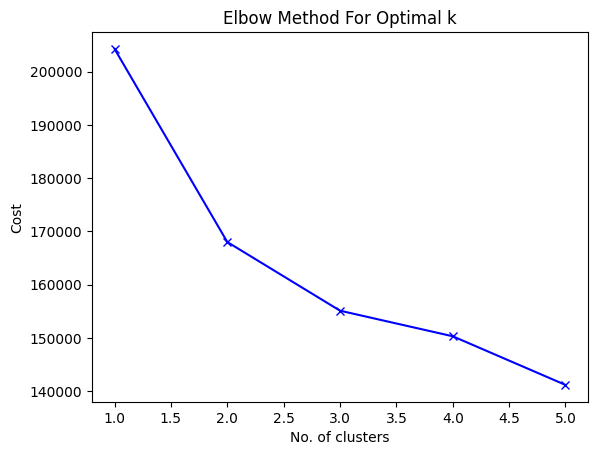

In [21]:
# Elbow curve to find optimal K in Huang init
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_cat)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

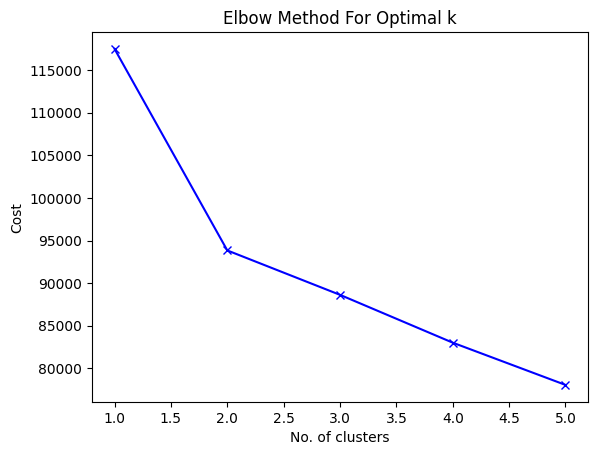

In [22]:
# For male data
# Elbow curve to find optimal K in Huang
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_male)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

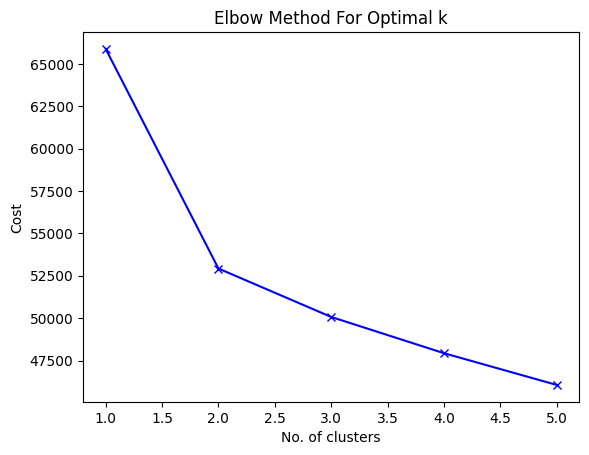

In [23]:
# For Female Data
# Elbow curve to find optimal K
cost = []
K = range(1,6)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=0)
    kmode.fit_predict(df_female)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

The code above is using the `Elbow` method to find the optimal number of clusters (K) for the general dataset, male and female dataset using the `Huang` initialization method in the KModes clustering algorithm. The cost of the clustering is calculated for each value of K (ranging from 1 to 5) and plotted on a graph. The code then displays the graph with the number of `clusters` on the x-axis and the cost on the y-axis. The `Elbow` method is a heuristic method used to determine the optimal number of clusters based on the point of inflection in the cost graph (i.e., the elbow point).

The best number os clusters for the general data in `Huang` Init is **2**
The best number os clusters for male Data in `Huang` Init is **2**
The best number os clusters for female Data in `Huang` Init is **2**

### Building the model using K-Mode with Huang initialization

In [24]:
# female data
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 5, verbose=0)
clusters_huang_1 = km_huang.fit_predict(df_female)
clusters_huang_1

array([1, 0, 0, ..., 0, 1, 1], dtype=uint16)

In [25]:
# male data
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 5, verbose=0)
clusters_huang_2 = km_huang.fit_predict(df_male)
clusters_huang_2

array([1, 0, 0, ..., 1, 1, 0], dtype=uint16)

The code above is using the KModes clustering algorithm to build a model for both male & female dataset with two clusters, using the `Huang` initialization method.

The `KModes` algorithm is a clustering algorithm designed to work with categorical data. It groups together similar instances based on the similarity of their categorical attributes.

The `n_init` parameter specifies the number of times the algorithm will be run with different initial centroids. The verbose parameter controls the level of output messages printed during the clustering process.

The `fit_predict` method fits the model to the dataset (df_female & df_female) and returns an array of cluster assignments, where each element represents the cluster assignment for the corresponding row of the input data.

The `clusters_huang_1 & clusters_huang_2` variable contains the cluster assignments for each row in the df_female & df_male dataset respectively. This variable can be used to perform further analysis of the data, such as evaluating the quality of the clustering or identifying which instances belong to which cluster.

In [26]:
# Inserting clusters in DataFrame
df_female.insert(0,"Cluster", clusters_huang_1, True)
df_male.insert(0, "Cluster", clusters_huang_2, True)

In [27]:
df_female.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease
0,1,1,3,1,2,0,0,0,0,1,0
3,0,1,3,2,4,0,0,0,0,1,1
7,0,1,6,3,3,2,2,0,0,1,1
11,1,1,4,1,2,0,0,0,0,1,0
12,1,1,1,1,2,0,0,0,0,0,0


In [28]:
df_male.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease
1,1,0,4,4,3,2,0,0,0,1,1
2,0,0,4,1,2,2,0,0,0,0,1
4,0,0,3,1,0,0,0,0,0,0,0
5,0,0,5,2,2,1,1,0,0,0,0
6,0,0,5,4,2,2,0,0,0,1,0


In [29]:
# replacing cluster column values to merge dataframes after
df_male["Cluster"].replace({0:2, 1:3}, inplace=True)
df_male.head()

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease
1,3,0,4,4,3,2,0,0,0,1,1
2,2,0,4,1,2,2,0,0,0,0,1
4,2,0,3,1,0,0,0,0,0,0,0
5,2,0,5,2,2,1,1,0,0,0,0
6,2,0,5,4,2,2,0,0,0,1,0


In [30]:
# merging female and male data
df_clusters = pd.concat([df_female, df_male], ignore_index=True, sort=False)
df_clusters.head(10)

,Cluster,gender,age_bin,BMI_Class,MAP_Class,cholesterol,glucose,smoke,alcohol,active,cardiovascular_disease
0,1,1,3,1,2,0,0,0,0,1,0
1,0,1,3,2,4,0,0,0,0,1,1
2,0,1,6,3,3,2,2,0,0,1,1
3,1,1,4,1,2,0,0,0,0,1,0
4,1,1,1,1,2,0,0,0,0,0,0
5,1,1,5,1,1,0,0,1,0,1,0
6,1,1,4,3,2,0,0,0,0,1,0
7,1,1,1,1,2,0,0,0,0,1,0
8,0,1,5,2,2,0,2,0,0,0,0
9,0,1,5,2,3,2,0,0,0,0,1


### Correlation

In [31]:
corr = df_clusters.corr()
cmap = sns.diverging_palette(2, 15, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

AttributeError: module 'numpy' has no attribute 'bool'

## Pycaret Experimentation

In [ ]:
clf_exp = setup(data = df_clusters, target = 'cardiovascular_disease', session_id=123)

,Description,Value
0,Session id,123
1,Target,cardiovascular_disease
2,Target type,Binary
3,Original data shape,"(60144, 11)"
4,Transformed data shape,"(60144, 11)"
5,Transformed train set shape,"(42100, 11)"
6,Transformed test set shape,"(18044, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best_model = compare_models(sort = 'F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8672,0.9485,0.8217,0.8977,0.8580,0.7338,0.7363,0.0500
catboost,CatBoost Classifier,0.8643,0.9478,0.8239,0.8899,0.8556,0.7279,0.7298,0.1100
xgboost,Extreme Gradient Boosting,0.8641,0.9474,0.8240,0.8895,0.8555,0.7276,0.7295,0.0410
rf,Random Forest Classifier,0.8606,0.9419,0.8221,0.8843,0.8521,0.7207,0.7224,0.0760
gbc,Gradient Boosting Classifier,0.8558,0.9370,0.8283,0.8702,0.8487,0.7111,0.7120,0.0310
et,Extra Trees Classifier,0.8585,0.9352,0.8131,0.8877,0.8487,0.7163,0.7188,0.0730
dt,Decision Tree Classifier,0.8581,0.9329,0.8118,0.8879,0.8481,0.7154,0.7180,0.0260
knn,K Neighbors Classifier,0.8388,0.9187,0.8406,0.8319,0.8359,0.6775,0.6781,0.1340
ada,Ada Boost Classifier,0.8314,0.9199,0.7932,0.8515,0.8212,0.6621,0.6637,0.0320
lr,Logistic Regression,0.8186,0.8796,0.7425,0.8668,0.7998,0.6357,0.6422,0.2710


In [ ]:
# # init the class
# exp = ClassificationExperiment()
# # init setup on exp
# exp.setup(df_clusters, target = 'cardiovascular_disease', session_id = 123)

In [ ]:
# # compare models using OOP
# exp.compare_models(sort = 'Precision')

## Machine Learning

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, precision_recall_fscore_support, confusion_matrix 
from sklearn.metrics import classification_report

In [ ]:
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.show()

In [ ]:
X = df_clusters.drop('cardiovascular_disease', axis=1)
y = df_clusters['cardiovascular_disease']

# Split the data into training and testing sets. 80% of data is training data, set aside other 20% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remaining 80% is split into valuation and test sets. 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

### Random Forest Classifier

In [ ]:
# Instantiate the models
rf_kmodes = RandomForestClassifier()
# Fit and evaluate the Random Forest Classifier model
rf_kmodes.fit(X_train, y_train)
y_val_pred = rf_kmodes.predict(X_val)
y_test_pred = rf_kmodes.predict(X_test)
# Cross-Validate the model
cv_scores = cross_val_score(rf_kmodes, X_train_val, y_train_val, cv=5).mean()

print("RandomForest Classifier")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cv_scores}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

RandomForest Classifier
Accuracy on validation set: 0.8602543852356804
Accuracy on test set: 0.8624158284146646
Cross-validation score: 0.8583809622778759
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      6172
           1       0.88      0.83      0.85      5857

    accuracy                           0.86     12029
   macro avg       0.86      0.86      0.86     12029
weighted avg       0.86      0.86      0.86     12029




In [ ]:
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_test_pred)}")

Confusion matrix:
[[5539  633]
 [1022 4835]]


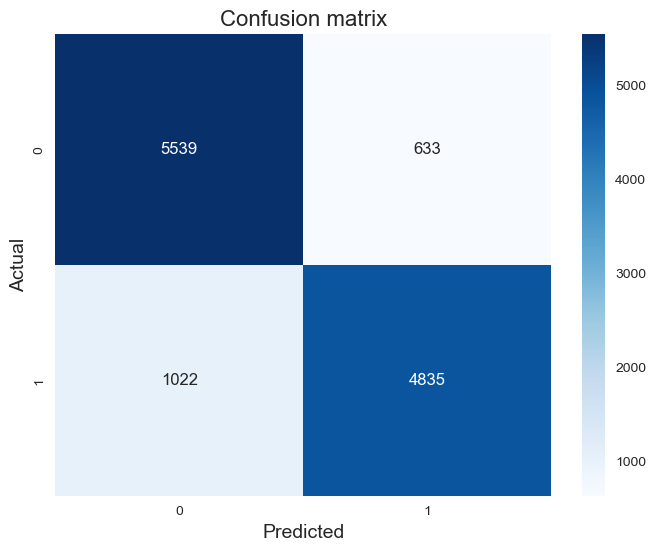

In [ ]:
plot_confusion_matrix(rf_kmodes, X_test, y_test);

### Light Gradient Boost (lightgbm)

`LightGBM` extends the `gradient` boosting algorithm by adding a type of automatic feature selection as well as focusing on boosting examples with larger gradients. This can result in a dramatic speedup of training and improved predictive performance.

In [ ]:
# Instantiate the models
lightgbm = LGBMClassifier()
# Fit and evaluate the Random Forest Classifier model
lightgbm.fit(X_train, y_train)
y_val_pred = lightgbm.predict(X_val)
y_test_pred = lightgbm.predict(X_test)
# Cross-Validate the model
cv_scores = cross_val_score(lightgbm, X_train_val, y_train_val, cv=5).mean()

print("Light Gradient Boost (lightgbm)")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cv_scores}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

Light Gradient Boost (lightgbm)
Accuracy on validation set: 0.8657411256131017
Accuracy on test set: 0.8674037742123202
Cross-validation score: 0.8648030759638367
Confusion matrix:
[[5592  580]
 [1015 4842]]
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      6172
           1       0.89      0.83      0.86      5857

    accuracy                           0.87     12029
   macro avg       0.87      0.87      0.87     12029
weighted avg       0.87      0.87      0.87     12029




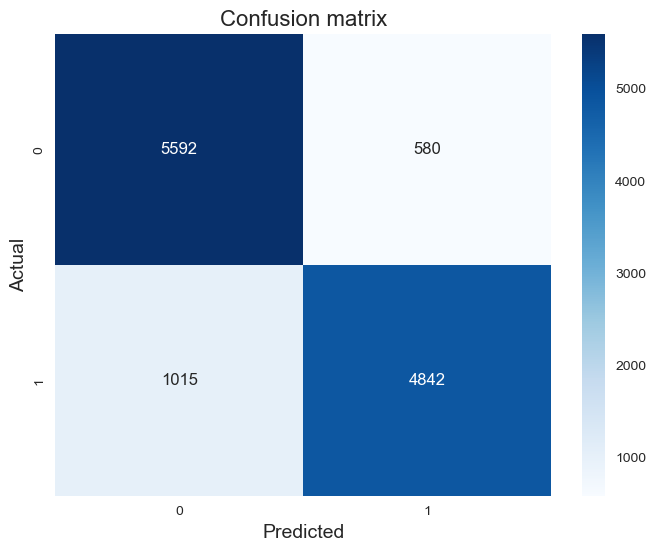

In [ ]:
plot_confusion_matrix(lightgbm, X_test, y_test);

### Extreme Gradient Boosting (XGBoost)

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

In [ ]:
# Instantiate the models
xgboost = XGBClassifier()

# Fit and evaluate the Random Forest Classifier model
xgboost.fit(X_train, y_train)
y_val_pred = xgboost.predict(X_val)
y_test_pred = xgboost.predict(X_test)

# Cross-Validate the model
cv_scores = cross_val_score(xgboost, X_train_val, y_train_val, cv=5).mean()

print("Extreme Gradient Boosting (XGBoost)")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cv_scores}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

Extreme Gradient Boosting (XGBoost)
Accuracy on validation set: 0.8640784770138831
Accuracy on test set: 0.8652423310333361
Cross-validation score: 0.8629949080328381
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      6172
           1       0.88      0.83      0.86      5857

    accuracy                           0.87     12029
   macro avg       0.87      0.86      0.86     12029
weighted avg       0.87      0.87      0.87     12029




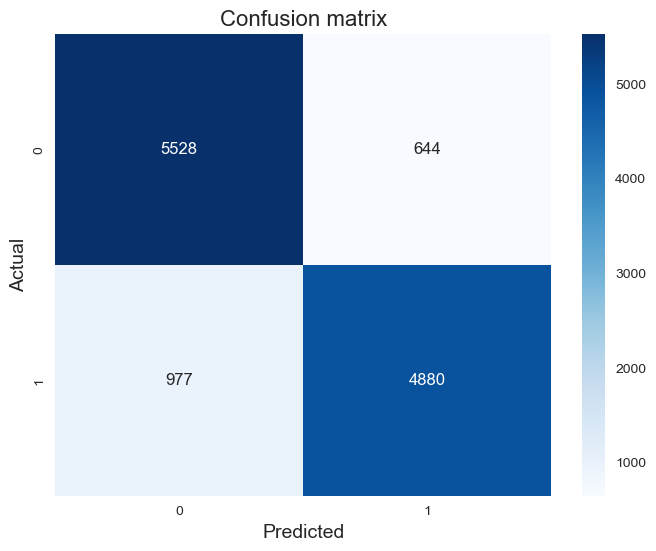

In [ ]:
plot_confusion_matrix(xgboost, X_test, y_test);

### CatBoost Classifier

In [ ]:
from catboost import CatBoostClassifier

# Instantiate the model
catboost = CatBoostClassifier(verbose=0)

# Fit and evaluate the model
catboost.fit(X_train, y_train)
y_val_pred = catboost.predict(X_val)
y_test_pred = catboost.predict(X_test)

# Cross-Validate the model
cv_scores = cross_val_score(catboost, X_train_val, y_train_val, cv=5).mean()

# Print evaluation metrics
print("CatBoost Classifier")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cv_scores}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

CatBoost Classifier
Accuracy on validation set: 0.8649098013134924
Accuracy on test set: 0.8648266688835314
Cross-validation score: 0.863618414215941
Confusion matrix:
[[5535  637]
 [ 989 4868]]
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      6172
           1       0.88      0.83      0.86      5857

    accuracy                           0.86     12029
   macro avg       0.87      0.86      0.86     12029
weighted avg       0.87      0.86      0.86     12029




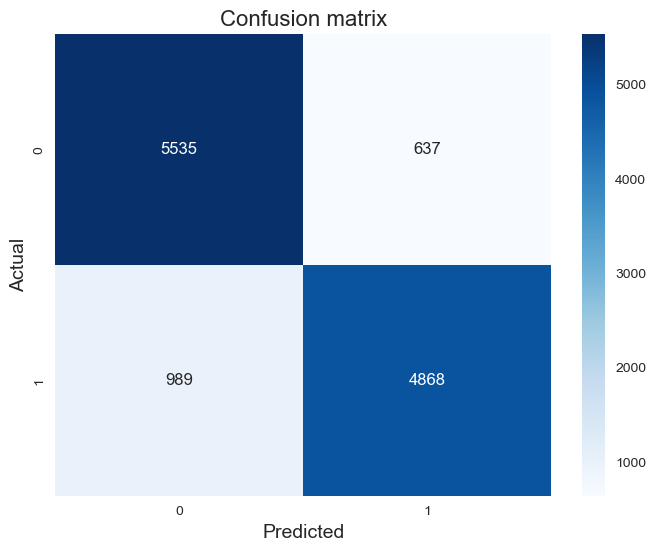

In [ ]:
plot_confusion_matrix(catboost, X_test, y_test);

### Gradient Boosting Classifier

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

In [ ]:
# Instantiate the models
gradboost_kmodes = GradientBoostingClassifier()
# Fit and evaluate the Gradientboost Classifier model
gradboost_kmodes.fit(X_train, y_train)
y_val_pred = gradboost_kmodes.predict(X_val)
y_test_pred = gradboost_kmodes.predict(X_test)
# Cross-validate the model
cv_scores = cross_val_score(gradboost_kmodes, X_train_val, y_train_val, cv=5).mean()

print("Gradientboost Classifier")
print(f"Accuracy on validation set: {accuracy_score(y_val, y_val_pred)}")
print(f"Accuracy on test set: {accuracy_score(y_test, y_test_pred)}")
print(f"Cross-validation score: {cv_scores}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"Classification report:\n{classification_report(y_test, y_test_pred)}\n")

Gradientboost Classifier
Accuracy on validation set: 0.8571784853271261
Accuracy on test set: 0.8599218555158368
Cross-validation score: 0.8551179465863037
Confusion matrix:
[[5364  808]
 [ 877 4980]]
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      6172
           1       0.86      0.85      0.86      5857

    accuracy                           0.86     12029
   macro avg       0.86      0.86      0.86     12029
weighted avg       0.86      0.86      0.86     12029




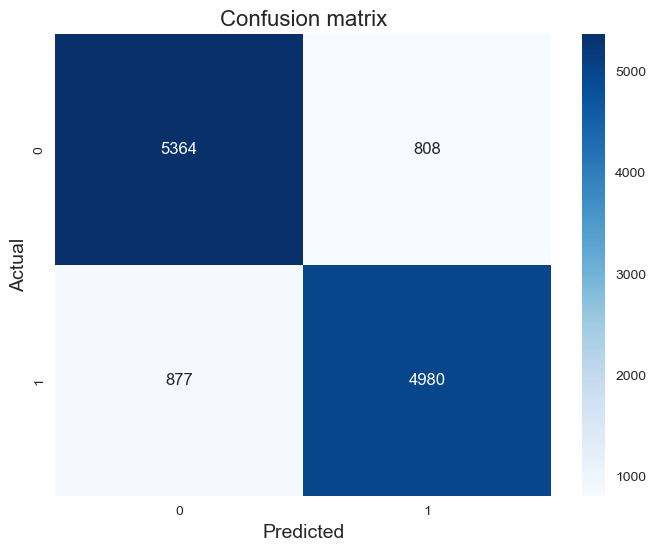

In [ ]:
plot_confusion_matrix(gradboost_kmodes, X_test, y_test);

### Appending all results

In [ ]:
# Define the models
models = [
    ('CatBoost Classifier', catboost),
    ('Random-Forest Classifier', rf_kmodes),
    ('Light Gradientboost', lightgbm),
    ('Extreme Gradientboost', xgboost),
    ('GradientBoost Classifier', gradboost_kmodes)
]

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Evaluate each model and append the results to the DataFrame
for model_name, model in models:
    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_val_pred = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_val_pred)
    p_val, r_val, f1_val, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')

    # Evaluate the model on the test set
    y_test_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_test_pred)
    p_test, r_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

    # Append the results to the DataFrame
    results_df = results_df.append({
        'Model': model_name,
        'Accuracy': f'Val: {acc_val:.3f}, Test: {acc_test:.3f}',
        'Precision': f'Val: {p_val:.3f}, Test: {p_test:.3f}',
        'Recall': f'Val: {r_val:.3f}, Test: {r_test:.3f}',
        'F1-Score': f'Val: {f1_val:.3f}, Test: {f1_test:.3f}'
    }, ignore_index=True)

# Print the results
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,CatBoost Classifier,"Val: 0.865, Test: 0.865","Val: 0.866, Test: 0.866","Val: 0.865, Test: 0.865","Val: 0.865, Test: 0.865"
1,Random-Forest Classifier,"Val: 0.860, Test: 0.863","Val: 0.861, Test: 0.864","Val: 0.860, Test: 0.863","Val: 0.859, Test: 0.863"
2,Light Gradientboost,"Val: 0.866, Test: 0.867","Val: 0.867, Test: 0.869","Val: 0.866, Test: 0.867","Val: 0.865, Test: 0.867"
3,Extreme Gradientboost,"Val: 0.864, Test: 0.865","Val: 0.865, Test: 0.866","Val: 0.864, Test: 0.865","Val: 0.864, Test: 0.865"
4,GradientBoost Classifier,"Val: 0.857, Test: 0.860","Val: 0.857, Test: 0.860","Val: 0.857, Test: 0.860","Val: 0.857, Test: 0.860"


In [ ]:
f1_sort = results_df.sort_values('F1-Score', ascending=False)
f1_sort

,Model,Accuracy,Precision,Recall,F1-Score
2,Light Gradientboost,"Val: 0.866, Test: 0.867","Val: 0.867, Test: 0.869","Val: 0.866, Test: 0.867","Val: 0.865, Test: 0.867"
0,CatBoost Classifier,"Val: 0.865, Test: 0.865","Val: 0.866, Test: 0.866","Val: 0.865, Test: 0.865","Val: 0.865, Test: 0.865"
3,Extreme Gradientboost,"Val: 0.864, Test: 0.865","Val: 0.865, Test: 0.866","Val: 0.864, Test: 0.865","Val: 0.864, Test: 0.865"
1,Random-Forest Classifier,"Val: 0.860, Test: 0.863","Val: 0.861, Test: 0.864","Val: 0.860, Test: 0.863","Val: 0.859, Test: 0.863"
4,GradientBoost Classifier,"Val: 0.857, Test: 0.860","Val: 0.857, Test: 0.860","Val: 0.857, Test: 0.860","Val: 0.857, Test: 0.860"


## Hyperparameter Tuning

### Light Gradient Boost (lightgbm)

In [ ]:
# Create a LightGBM model
lgbm = LGBMClassifier()

# Define the parameter grid for GridSearchCV
lgbm_params_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'num_leaves': [7, 15, 31],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Define the parameter grid for RandomSearchCV
lgbm_params_random = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'num_leaves': [7, 15, 31],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

In [ ]:
# Perform GridSearchCV for LightGBM
lgbm_grid = GridSearchCV(lgbm, lgbm_params_grid, cv=5, scoring='f1')
lgbm_grid.fit(X_train, y_train)
print("LightGBM GridSearchCV Best Parameters: ", lgbm_grid.best_params_)
print("LightGBM GridSearchCV Best Score: ", lgbm_grid.best_score_)

LightGBM GridSearchCV Best Parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 31, 'reg_alpha': 0.5, 'reg_lambda': 0.1}
LightGBM GridSearchCV Best Score:  0.8567211114103482


In [ ]:
# Train LightGBM model with the best hyperparameters
lgbm_grid_best = LGBMClassifier(learning_rate=0.1, max_depth=7, num_leaves=31, reg_alpha= 0.5, reg_lambda= 0.1, random_state=42)
lgbm_grid_best.fit(X_train, y_train)

# Evaluate the model on validation set
y_pred = lgbm_grid_best.predict(X_val)
acc_val = accuracy_score(y_val, y_pred)

# Evaluate the model on test set
y_pred = lgbm_grid_best.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(lgbm_grid_best, X_train_val, y_train_val, cv=5)

# Print the performance metrics
print("Light Gradient Boost - GridSearchCV")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

Light Gradient Boost - GridSearchCV
Accuracy on validation set: 86.64%
Accuracy on test set: 86.79%
Cross-validation score: 86.51% (+/- 0.95%)
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      6172
           1       0.89      0.83      0.86      5857

    accuracy                           0.87     12029
   macro avg       0.87      0.87      0.87     12029
weighted avg       0.87      0.87      0.87     12029



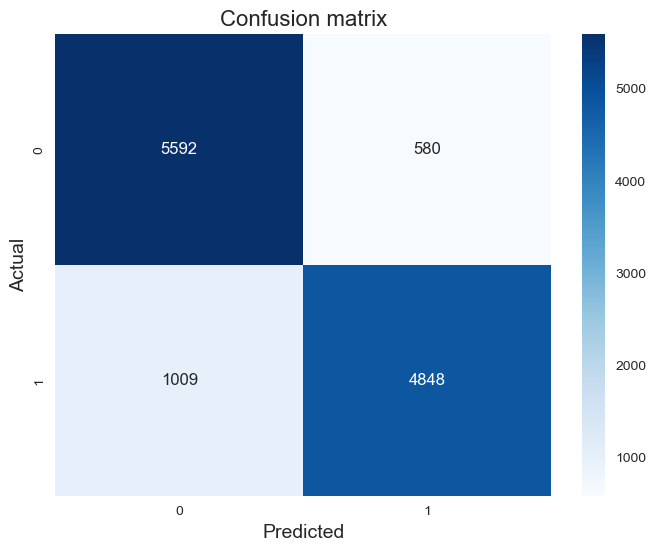

In [ ]:
plot_confusion_matrix(lgbm_grid_best, X_test, y_test);

In [ ]:
# Perform RandomSearchCV for LightGBM
lgbm_random = RandomizedSearchCV(lgbm, lgbm_params_random, cv=5, scoring='f1', n_iter=10, verbose=0)
lgbm_random.fit(X_train, y_train)
print("LightGBM RandomSearchCV Best Parameters: ", lgbm_random.best_params_)
print("LightGBM RandomSearchCV Best Score: ", lgbm_random.best_score_)

LightGBM RandomSearchCV Best Parameters:  {'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 31, 'max_depth': 3, 'learning_rate': 1}
LightGBM RandomSearchCV Best Score:  0.8549872895300453


In [ ]:
# Train LightGBM model with the best hyperparameters
lgbm_rand_best = LGBMClassifier(reg_lambda= 0.5,reg_alpha= 0.5, num_leaves=31, max_depth=3, learning_rate=1, random_state=42)
lgbm_rand_best.fit(X_train, y_train)

# Evaluate the model on validation set
y_pred = lgbm_rand_best.predict(X_val)
acc_val = accuracy_score(y_val, y_pred)

# Evaluate the model on test set
y_pred = lgbm_rand_best.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(lgbm_rand_best, X_train_val, y_train_val, cv=5)

# Print the performance metrics
print("Light Gradient Boost - RandomSearchCV")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

Light Gradient Boost - RandomSearchCV
Accuracy on validation set: 86.49%
Accuracy on test set: 86.67%
Cross-validation score: 86.38% (+/- 0.79%)
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      6172
           1       0.89      0.83      0.86      5857

    accuracy                           0.87     12029
   macro avg       0.87      0.87      0.87     12029
weighted avg       0.87      0.87      0.87     12029



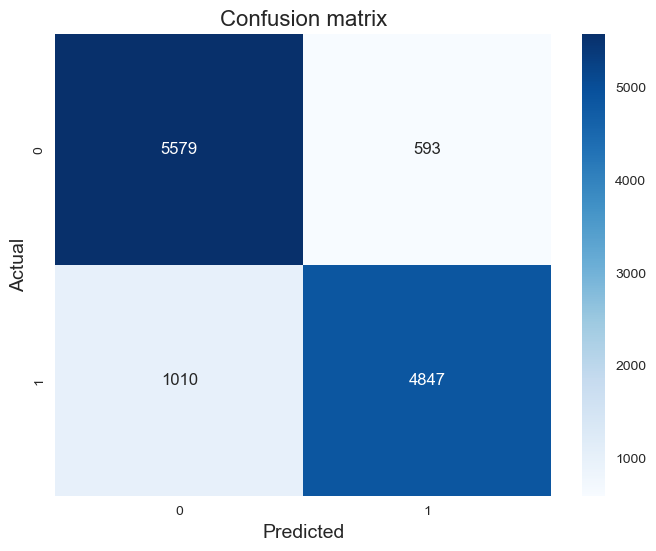

In [ ]:
plot_confusion_matrix(lgbm_rand_best, X_test, y_test);

### Extreme Gradient Boosting (XGBoost)

In [ ]:
# Create an XGBoost model
xgb = XGBClassifier()

# Define the parameter grid for GridSearchCV
xgb_params_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Define the parameter grid for RandomSearchCV
xgb_params_random = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

In [ ]:
# # Perform GridSearchCV for XGBoost
# xgb_grid = GridSearchCV(xgb, xgb_params_grid, cv=5, scoring='f1')
# xgb_grid.fit(X_train, y_train)
# print("XGBoost GridSearchCV Best Parameters: ", xgb_grid.best_params_)
# print("XGBoost GridSearchCV Best Score: ", xgb_grid.best_score_)

Took too long to run sucessfully

In [ ]:
# Perform RandomSearchCV for XGBoost
xgb_random = RandomizedSearchCV(xgb, xgb_params_random, cv=5, scoring='f1', n_iter=10)
xgb_random.fit(X_train, y_train)
print("XGBoost RandomSearchCV Best Parameters: ", xgb_random.best_params_)
print("XGBoost RandomSearchCV Best Score: ", xgb_random.best_score_)

XGBoost RandomSearchCV Best Parameters:  {'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 0, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.5}
XGBoost RandomSearchCV Best Score:  0.854460449373468


In [ ]:
# Train XGBoost model with the best hyperparameters
xgboost_rand_best = XGBClassifier(subsample= 0.5,reg_lambda= 0,reg_alpha= 0, max_depth=7, learning_rate=0.1, gamma= 0, colsample_bytree= 0.5, random_state=42)
xgboost_rand_best.fit(X_train, y_train)

# Evaluate the model on validation set
y_pred = xgboost_rand_best.predict(X_val)
acc_val = accuracy_score(y_val, y_pred)

# Evaluate the model on test set
y_pred = xgboost_rand_best.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(xgboost_rand_best, X_train_val, y_train_val, cv=5)

# Print the performance metrics
print("XGBoost - RandomSearchCV")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

XGBoost - RandomSearchCV
Accuracy on validation set: 86.48%
Accuracy on test set: 86.87%
Cross-validation score: 86.38% (+/- 0.77%)
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      6172
           1       0.89      0.83      0.86      5857

    accuracy                           0.87     12029
   macro avg       0.87      0.87      0.87     12029
weighted avg       0.87      0.87      0.87     12029



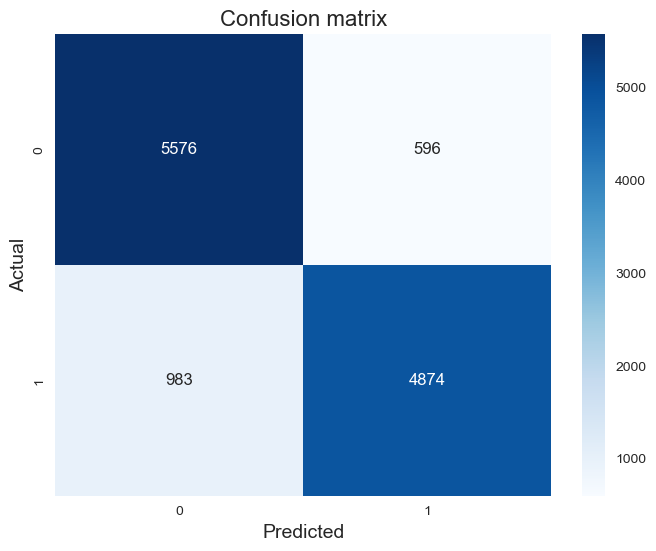

In [ ]:
plot_confusion_matrix(xgboost_rand_best, X_test, y_test);

## Appending all result

In [ ]:
# Define the models
models = [
    ('CatBoost Classifier', catboost),
    ('Random-Forest Classifier', rf_kmodes),
    ('LightGbm', lightgbm),
    ('Extreme Gradientboost', xgboost),
    ('GradientBoost Classifier', gradboost_kmodes),
    ('LightGbm GridSearchCV', lgbm_grid_best),
    ('LightGbm RandomSearchCV', lgbm_rand_best),
    ('XGBoost RandomSearchCV', xgboost_rand_best)
]

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Evaluate each model and append the results to the DataFrame
for model_name, model in models:
    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the validation set
    y_val_pred = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_val_pred)
    p_val, r_val, f1_val, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')

    # Evaluate the model on the test set
    y_test_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_test_pred)
    p_test, r_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

    # Append the results to the DataFrame
    results_df = results_df.append({
        'Model': model_name,
        'Accuracy': f'Val: {acc_val:.4f}, Test: {acc_test:.4f}',
        'Precision': f'Val: {p_val:.4f}, Test: {p_test:.4f}',
        'Recall': f'Val: {r_val:.4f}, Test: {r_test:.4f}',
        'F1-Score': f'Val: {f1_val:.4f}, Test: {f1_test:.4f}'
    }, ignore_index=True)

# Print the results
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,CatBoost Classifier,"Val: 0.8649, Test: 0.8648","Val: 0.8661, Test: 0.8659","Val: 0.8649, Test: 0.8648","Val: 0.8647, Test: 0.8646"
1,Random-Forest Classifier,"Val: 0.8604, Test: 0.8630","Val: 0.8618, Test: 0.8644","Val: 0.8604, Test: 0.8630","Val: 0.8601, Test: 0.8627"
2,LightGbm,"Val: 0.8657, Test: 0.8674","Val: 0.8675, Test: 0.8691","Val: 0.8657, Test: 0.8674","Val: 0.8654, Test: 0.8671"
3,Extreme Gradientboost,"Val: 0.8641, Test: 0.8652","Val: 0.8651, Test: 0.8662","Val: 0.8641, Test: 0.8652","Val: 0.8639, Test: 0.8650"
4,GradientBoost Classifier,"Val: 0.8572, Test: 0.8599","Val: 0.8572, Test: 0.8599","Val: 0.8572, Test: 0.8599","Val: 0.8571, Test: 0.8599"
5,LightGbm GridSearchCV,"Val: 0.8664, Test: 0.8679","Val: 0.8681, Test: 0.8695","Val: 0.8664, Test: 0.8679","Val: 0.8661, Test: 0.8676"
6,LightGbm RandomSearchCV,"Val: 0.8649, Test: 0.8667","Val: 0.8665, Test: 0.8683","Val: 0.8649, Test: 0.8667","Val: 0.8646, Test: 0.8665"
7,XGBoost RandomSearchCV,"Val: 0.8648, Test: 0.8687","Val: 0.8663, Test: 0.8701","Val: 0.8648, Test: 0.8687","Val: 0.8646, Test: 0.8685"


In [ ]:
f1_sort = results_df.sort_values('F1-Score', ascending=False)
f1_sort

,Model,Accuracy,Precision,Recall,F1-Score
5,LightGbm GridSearchCV,"Val: 0.8664, Test: 0.8679","Val: 0.8681, Test: 0.8695","Val: 0.8664, Test: 0.8679","Val: 0.8661, Test: 0.8676"
2,LightGbm,"Val: 0.8657, Test: 0.8674","Val: 0.8675, Test: 0.8691","Val: 0.8657, Test: 0.8674","Val: 0.8654, Test: 0.8671"
0,CatBoost Classifier,"Val: 0.8649, Test: 0.8648","Val: 0.8661, Test: 0.8659","Val: 0.8649, Test: 0.8648","Val: 0.8647, Test: 0.8646"
7,XGBoost RandomSearchCV,"Val: 0.8648, Test: 0.8687","Val: 0.8663, Test: 0.8701","Val: 0.8648, Test: 0.8687","Val: 0.8646, Test: 0.8685"
6,LightGbm RandomSearchCV,"Val: 0.8649, Test: 0.8667","Val: 0.8665, Test: 0.8683","Val: 0.8649, Test: 0.8667","Val: 0.8646, Test: 0.8665"
3,Extreme Gradientboost,"Val: 0.8641, Test: 0.8652","Val: 0.8651, Test: 0.8662","Val: 0.8641, Test: 0.8652","Val: 0.8639, Test: 0.8650"
1,Random-Forest Classifier,"Val: 0.8604, Test: 0.8630","Val: 0.8618, Test: 0.8644","Val: 0.8604, Test: 0.8630","Val: 0.8601, Test: 0.8627"
4,GradientBoost Classifier,"Val: 0.8572, Test: 0.8599","Val: 0.8572, Test: 0.8599","Val: 0.8572, Test: 0.8599","Val: 0.8571, Test: 0.8599"


From the table, `LightGbm` using the `default parameter` and `GridSearchCV`, and `XGBoost` using `RandomizedSearchCV` performed better when it comes to `F1-Score` metrics, so we will implement `Voting CLassifier` on the 3 metrics and check if the`F1-Score` metric will be better.

## Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

vc_hard = VotingClassifier(estimators=[('Light Gradientboost', lightgbm),
                                       ('LightGbm GridSearchCV', lgbm_grid_best),
                                       ('XGBoost RandomSearchCV', xgboost_rand_best)],
                           voting='hard')
vc_hard.fit(X_train,y_train)

# Evaluate the model on validation set
y_val_pred = vc_hard.predict(X_val)
acc_val = accuracy_score(y_val, y_val_pred)
p_val, r_val, f1_val, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')

# Evaluate the model on test set
y_test_pred = vc_hard.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
p_test, r_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

# Evaluate the model using cross-validation
cv_scores = cross_val_score(vc_hard, X_train_val, y_train_val, cv=5)

# Append the results to the DataFrame
results_df = results_df.append({
    'Model': "Voting Classifier - Hard",
    'Accuracy': f'Val: {acc_val:.4f}, Test: {acc_test:.4f}',
    'Precision': f'Val: {p_val:.4f}, Test: {p_test:.4f}',
    'Recall': f'Val: {r_val:.4f}, Test: {r_test:.4f}',
    'F1-Score': f'Val: {f1_val:.4f}, Test: {f1_test:.4f}'
}, ignore_index=True)

# Print the performance metrics
print("Voting Classifier - Hard")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

Voting Classifier - Hard
Accuracy on validation set: 86.64%
Accuracy on test set: 86.77%
Cross-validation score: 86.46% (+/- 0.92%)
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      6172
           1       0.89      0.83      0.86      5857

    accuracy                           0.87     12029
   macro avg       0.87      0.87      0.87     12029
weighted avg       0.87      0.87      0.87     12029



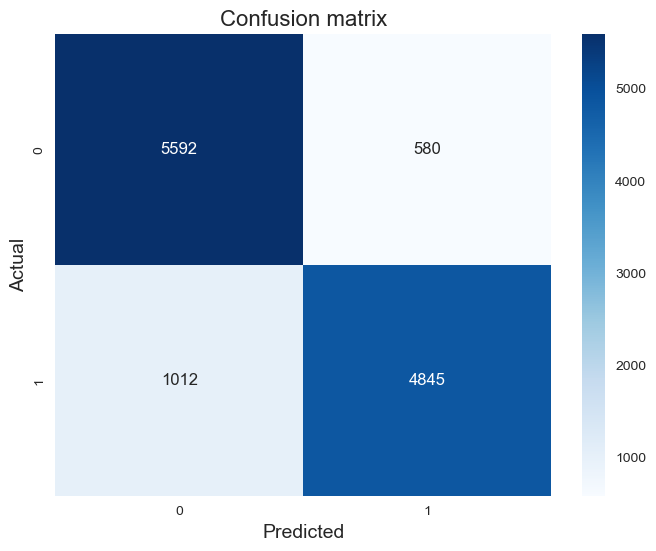

In [ ]:
plot_confusion_matrix(vc_hard, X_test, y_test);

In [ ]:
from sklearn.ensemble import VotingClassifier

vc_soft = VotingClassifier(estimators=[('Light Gradientboost', lightgbm),
                                       ('LightGbm GridSearchCV', lgbm_grid_best),
                                       ('XGBoost RandomSearchCV', xgboost_rand_best)],
                           voting='soft')
vc_soft.fit(X_train,y_train)

# Evaluate the model on validation set
y_val_pred = vc_soft.predict(X_val)
acc_val = accuracy_score(y_val, y_val_pred)
p_val, r_val, f1_val, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')

# Evaluate the model on test set
y_test_pred = vc_soft.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
p_test, r_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')

# Evaluate the model using cross-validation
cv_scores = cross_val_score(vc_soft, X_train_val, y_train_val, cv=5)

# Append the results to the DataFrame
results_df = results_df.append({
    'Model': "Voting Classifier - Soft",
    'Accuracy': f'Val: {acc_val:.4f}, Test: {acc_test:.4f}',
    'Precision': f'Val: {p_val:.4f}, Test: {p_test:.4f}',
    'Recall': f'Val: {r_val:.4f}, Test: {r_test:.4f}',
    'F1-Score': f'Val: {f1_val:.4f}, Test: {f1_test:.4f}'
}, ignore_index=True)

# Print the performance metrics
print("Voting Classifier - Soft")
print("Accuracy on validation set: {:.2f}%".format(acc_val*100))
print("Accuracy on test set: {:.2f}%".format(acc_test*100))
print("Cross-validation score: {:.2f}% (+/- {:.2f}%)".format(cv_scores.mean()*100, cv_scores.std()*2*100))
print("Classification report:\n", classification_report(y_test, y_pred))

Voting Classifier - Soft
Accuracy on validation set: 86.66%
Accuracy on test set: 86.82%
Cross-validation score: 86.51% (+/- 0.80%)
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      6172
           1       0.89      0.83      0.86      5857

    accuracy                           0.87     12029
   macro avg       0.87      0.87      0.87     12029
weighted avg       0.87      0.87      0.87     12029



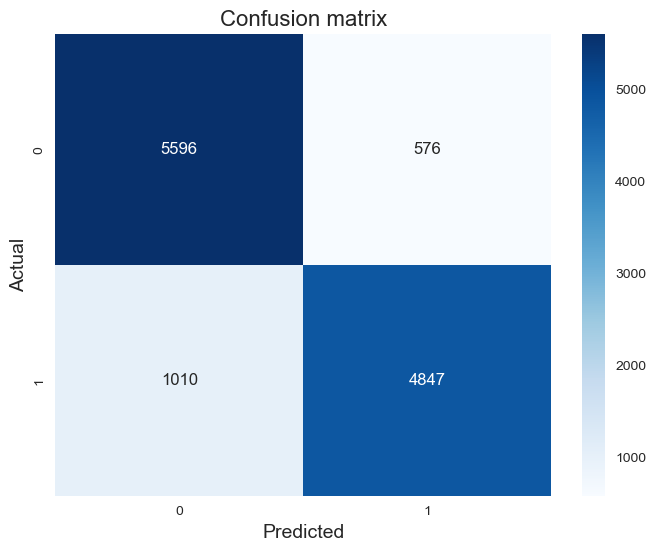

In [ ]:
plot_confusion_matrix(vc_soft, X_test, y_test);

In [ ]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,CatBoost Classifier,"Val: 0.8649, Test: 0.8648","Val: 0.8661, Test: 0.8659","Val: 0.8649, Test: 0.8648","Val: 0.8647, Test: 0.8646"
1,Random-Forest Classifier,"Val: 0.8604, Test: 0.8630","Val: 0.8618, Test: 0.8644","Val: 0.8604, Test: 0.8630","Val: 0.8601, Test: 0.8627"
2,LightGbm,"Val: 0.8657, Test: 0.8674","Val: 0.8675, Test: 0.8691","Val: 0.8657, Test: 0.8674","Val: 0.8654, Test: 0.8671"
3,Extreme Gradientboost,"Val: 0.8641, Test: 0.8652","Val: 0.8651, Test: 0.8662","Val: 0.8641, Test: 0.8652","Val: 0.8639, Test: 0.8650"
4,GradientBoost Classifier,"Val: 0.8572, Test: 0.8599","Val: 0.8572, Test: 0.8599","Val: 0.8572, Test: 0.8599","Val: 0.8571, Test: 0.8599"
5,LightGbm GridSearchCV,"Val: 0.8664, Test: 0.8679","Val: 0.8681, Test: 0.8695","Val: 0.8664, Test: 0.8679","Val: 0.8661, Test: 0.8676"
6,LightGbm RandomSearchCV,"Val: 0.8649, Test: 0.8667","Val: 0.8665, Test: 0.8683","Val: 0.8649, Test: 0.8667","Val: 0.8646, Test: 0.8665"
7,XGBoost RandomSearchCV,"Val: 0.8648, Test: 0.8687","Val: 0.8663, Test: 0.8701","Val: 0.8648, Test: 0.8687","Val: 0.8646, Test: 0.8685"
8,Voting Classifier - Hard,"Val: 0.8664, Test: 0.8677","Val: 0.8681, Test: 0.8693","Val: 0.8664, Test: 0.8677","Val: 0.8661, Test: 0.8674"
9,Voting Classifier - Soft,"Val: 0.8666, Test: 0.8682","Val: 0.8683, Test: 0.8698","Val: 0.8666, Test: 0.8682","Val: 0.8663, Test: 0.8679"


In [ ]:
f1_sort = results_df.sort_values('F1-Score', ascending=False)
f1_sort

,Model,Accuracy,Precision,Recall,F1-Score
9,Voting Classifier - Soft,"Val: 0.8666, Test: 0.8682","Val: 0.8683, Test: 0.8698","Val: 0.8666, Test: 0.8682","Val: 0.8663, Test: 0.8679"
5,LightGbm GridSearchCV,"Val: 0.8664, Test: 0.8679","Val: 0.8681, Test: 0.8695","Val: 0.8664, Test: 0.8679","Val: 0.8661, Test: 0.8676"
8,Voting Classifier - Hard,"Val: 0.8664, Test: 0.8677","Val: 0.8681, Test: 0.8693","Val: 0.8664, Test: 0.8677","Val: 0.8661, Test: 0.8674"
2,LightGbm,"Val: 0.8657, Test: 0.8674","Val: 0.8675, Test: 0.8691","Val: 0.8657, Test: 0.8674","Val: 0.8654, Test: 0.8671"
0,CatBoost Classifier,"Val: 0.8649, Test: 0.8648","Val: 0.8661, Test: 0.8659","Val: 0.8649, Test: 0.8648","Val: 0.8647, Test: 0.8646"
7,XGBoost RandomSearchCV,"Val: 0.8648, Test: 0.8687","Val: 0.8663, Test: 0.8701","Val: 0.8648, Test: 0.8687","Val: 0.8646, Test: 0.8685"
6,LightGbm RandomSearchCV,"Val: 0.8649, Test: 0.8667","Val: 0.8665, Test: 0.8683","Val: 0.8649, Test: 0.8667","Val: 0.8646, Test: 0.8665"
3,Extreme Gradientboost,"Val: 0.8641, Test: 0.8652","Val: 0.8651, Test: 0.8662","Val: 0.8641, Test: 0.8652","Val: 0.8639, Test: 0.8650"
1,Random-Forest Classifier,"Val: 0.8604, Test: 0.8630","Val: 0.8618, Test: 0.8644","Val: 0.8604, Test: 0.8630","Val: 0.8601, Test: 0.8627"
4,GradientBoost Classifier,"Val: 0.8572, Test: 0.8599","Val: 0.8572, Test: 0.8599","Val: 0.8572, Test: 0.8599","Val: 0.8571, Test: 0.8599"


In [ ]:
precision_sort = results_df.sort_values('Precision', ascending=False)
precision_sort

,Model,Accuracy,Precision,Recall,F1-Score
9,Voting Classifier - Soft,"Val: 0.8666, Test: 0.8682","Val: 0.8683, Test: 0.8698","Val: 0.8666, Test: 0.8682","Val: 0.8663, Test: 0.8679"
5,LightGbm GridSearchCV,"Val: 0.8664, Test: 0.8679","Val: 0.8681, Test: 0.8695","Val: 0.8664, Test: 0.8679","Val: 0.8661, Test: 0.8676"
8,Voting Classifier - Hard,"Val: 0.8664, Test: 0.8677","Val: 0.8681, Test: 0.8693","Val: 0.8664, Test: 0.8677","Val: 0.8661, Test: 0.8674"
2,LightGbm,"Val: 0.8657, Test: 0.8674","Val: 0.8675, Test: 0.8691","Val: 0.8657, Test: 0.8674","Val: 0.8654, Test: 0.8671"
6,LightGbm RandomSearchCV,"Val: 0.8649, Test: 0.8667","Val: 0.8665, Test: 0.8683","Val: 0.8649, Test: 0.8667","Val: 0.8646, Test: 0.8665"
7,XGBoost RandomSearchCV,"Val: 0.8648, Test: 0.8687","Val: 0.8663, Test: 0.8701","Val: 0.8648, Test: 0.8687","Val: 0.8646, Test: 0.8685"
0,CatBoost Classifier,"Val: 0.8649, Test: 0.8648","Val: 0.8661, Test: 0.8659","Val: 0.8649, Test: 0.8648","Val: 0.8647, Test: 0.8646"
3,Extreme Gradientboost,"Val: 0.8641, Test: 0.8652","Val: 0.8651, Test: 0.8662","Val: 0.8641, Test: 0.8652","Val: 0.8639, Test: 0.8650"
1,Random-Forest Classifier,"Val: 0.8604, Test: 0.8630","Val: 0.8618, Test: 0.8644","Val: 0.8604, Test: 0.8630","Val: 0.8601, Test: 0.8627"
4,GradientBoost Classifier,"Val: 0.8572, Test: 0.8599","Val: 0.8572, Test: 0.8599","Val: 0.8572, Test: 0.8599","Val: 0.8571, Test: 0.8599"


From the table above, we have two models performing better which are `Voting Classifier` and `Light Gradientboost`. I'm going to save both model and this will be the end of the project.

## Feature Importance

In [ ]:
# Get the feature importances
importances = lightgbm.feature_importances_
# Get the column names
columns = X_train.columns
# Create a dictionary to map the importances to column names
importances_dict = dict(zip(columns, importances))
# Sort the dictionary by importance in descending order
sorted_importances_dict = dict(sorted(importances_dict.items(), key=lambda x: x[1], reverse=True))
# Print the important features in descending order
print("Important features for Light Gradient Boosting Model:")
for feature, importance in sorted_importances_dict.items():
    print(f"{feature}: {importance}")

Important features for Light Gradient Boosting Model:
age_bin: 782
BMI_Class: 650
Cluster: 524
MAP_Class: 499
cholesterol: 154
glucose: 112
smoke: 101
active: 92
alcohol: 67
gender: 19


## Saving both models

In [ ]:
import pickle

pickle.dump(lgbm_grid_best, open('../../Models/lightgbm.pkl', 'wb'))
pickle.dump(vc_soft, open('../../Models/voting_classifier.pkl', 'wb'))

In [36]:
import pickle
from lightgbm import LGBMClassifier

pickled_model=pickle.load(open('../../Models/voting_classifier.pkl','rb'))

payload = {
        "Cluster": 1,
        "gender": 1,
        "age_bin": 34,
        "BMI_Class": 20,
        "MAP_Class": 1,
        "cholesterol": 1,
        "glucose": 1,
        "smoke": 1,
        "alcohol": 1,
        "active": 1
    }

res = pickled_model.predict(payload)

print(res)


OSError: dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <D21A7969-4567-3BC7-94ED-6A9E83AE9D78> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

**Author:** `Jammal Adeyemi`